<a href="https://colab.research.google.com/github/intel-analytics/BigDL/blob/branch-2.0/python/orca/colab-notebook/quickstart/ray_parameter_server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

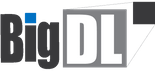
---

##### Copyright 2016 The BigDL Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install BigDL Orca**

You can install the latest pre-release version using `!pip install --pre --upgrade bigdl-orca`. 

In [ ]:
# Install latest pre-release version of BigDL Orca with ray
# Installing BigDL Orca from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca[ray]

## **RayOnSpark: run Ray programs directly on Big Data clusters**

In this guide, we will describe how to use RayOnSpark to directly run Ray programs on Big Data clusters in 2 simple steps.

In [1]:
# import necesary libraries and modules
from bigdl.orca import init_orca_context, stop_orca_context, OrcaContext
import ray
import time
import numpy as np

### **Step 1: Initialize**
We recommend using `init_orca_context` to initiate and run BigDL on the underlying cluster. The Ray cluster would be launched automatically by specifying `init_ray_on_spark=True`.

In [ ]:
OrcaContext.log_output = True # recommended to set it to True when running BigDL in Jupyter notebook (this will display terminal's  stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    sc = init_orca_context(cluster_mode="local", cores=4, memory="10g", init_ray_on_spark=True)  # run in local mode
elif cluster_mode == "k8s":
    sc = init_orca_context(cluster_mode="k8s", num_nodes=2, cores=2, memory="10g", init_ray_on_spark=True)  # run on K8s cluster
elif cluster_mode == "yarn":
    sc = init_orca_context(cluster_mode="yarn", num_nodes=2, cores=2, memory="10g", init_ray_on_spark=True)  # run on Hadoop YARN cluster

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://bigdl.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note:** You should `export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir` when running on Hadoop YARN cluster.

You can retrieve the information of the Ray cluster via `OrcaContext`:

In [3]:
ray_ctx = OrcaContext.get_ray_context()
address_info = ray_ctx.address_info  # The dictionary information of the ray cluster, including node_ip_address, object_store_address, webui_url, etc.
redis_address = ray_ctx.redis_address  # The redis address of the ray cluster.
print(address_info['object_store_address'])

/tmp/ray/session_2021-03-30_14-23-11_812916_29840/sockets/plasma_store


### **Step 2: Run Ray Applications**
After the initialization, you can directly write Ray code inline with your Spark code, and run Ray programs on the underlying existing Big Data clusters. Ray [tasks](https://docs.ray.io/en/master/walkthrough.html#remote-functions-tasks) and [actors](https://docs.ray.io/en/master/actors.html) would be launched across the cluster.

The following example uses actor handles to implement a parameter server example for distributed asynchronous stochastic gradient descent. This is a simple Ray example for demonstration purpose. Similarly, you can write other Ray applications as you wish.

A parameter server is simply an object that stores the parameters (or "weights") of a machine learning model (this could be a neural network, a linear model, or something else). It exposes two methods: one for getting the parameters and one for updating the parameters.

By adding the `@ray.remote` decorator, the `ParameterServer` class becomes a Ray actor.

In [4]:
dim = 10
@ray.remote
class ParameterServer(object):
    def __init__(self, dim):
        self.parameters = np.zeros(dim)
    
    def get_parameters(self):
        return self.parameters
    
    def update_parameters(self, update):
        self.parameters += update

ps = ParameterServer.remote(dim)

In a typical machine learning training application, worker processes will run in an infinite loop that does the following:

1. Get the latest parameters from the parameter server.
2. Compute an update to the parameters (using the current parameters and some data).
3. Send the update to the parameter server.

By adding the `@ray.remote` decorator, the `worker` function becomes a Ray remote function.

In [5]:
@ray.remote
def worker(ps, dim, num_iters):
    for _ in range(num_iters):
        # Get the latest parameters.
        parameters = ray.get(ps.get_parameters.remote())
        # Compute an update.
        update = 1e-3 * parameters + np.ones(dim)
        # Update the parameters.
        ps.update_parameters.remote(update)
        # Sleep a little to simulate a real workload.
        time.sleep(0.5)

# Test that worker is implemented correctly. You do not need to change this line.
ray.get(worker.remote(ps, dim, 1))

# Start two workers.
worker_results = [worker.remote(ps, dim, 100) for _ in range(2)]

As the worker tasks are executing, you can query the parameter server from the driver and see the parameters changing in the background.

In [6]:
print(ray.get(ps.get_parameters.remote()))

[9.03608413 9.03608413 9.03608413 9.03608413 9.03608413 9.03608413
 9.03608413 9.03608413 9.03608413 9.03608413]


**Note:** You should call `stop_orca_context()` when your program finishes:

In [ ]:
stop_orca_context()